### Imports

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [46]:
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.preprocessing import image
from tensorflow.keras import layers
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import seaborn as sn
import pandas as pd 
import numpy as np
import scipy
import cv2

### Collab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/VisionTransformer_ROS
! ls

/content/drive/My Drive/VisionTransformer0.2
fer2013.csv


In [4]:
data_path = './fer2013.csv'
!pwd
!ls

/content/drive/My Drive/VisionTransformer0.2
fer2013.csv


### Exploratory Data Analysis

Reading data

In [3]:
data_path = "D:/Everything/Development Setup/fer2013.csv"
data = pd.read_csv(data_path)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The dataset consists of 35887 instances which are divided as follows: 

In [4]:
instanceCount = data.groupby('Usage').size()
instanceCount

Usage
PrivateTest     3589
PublicTest      3589
Training       28709
dtype: int64

In [5]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

Checking datatypes of the dataframe variables

In [6]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

These datatypes will be changed accordingly. The pixels variable should be an array of pixel values, the emotion variable should be categorical for the model to accept it.

In [7]:
# Checking null values in dataframe
data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no nulls in the dataframe.

let's check the duplicates within the dataframe. 

In [8]:
duplicates = data[data.duplicated(subset='pixels')]
duplicates

,emotion,pixels,Usage
675,5,255 255 255 255 255 255 255 237 217 146 185 11...,Training
718,2,114 95 82 84 85 120 108 97 83 64 68 85 80 86 1...,Training
1145,5,205 204 205 205 204 203 203 203 202 202 203 20...,Training
1266,3,201 218 246 178 74 62 63 78 85 83 71 65 64 67 ...,Training
1289,5,238 69 24 32 34 33 27 30 41 49 60 64 47 65 80 ...,Training
...,...,...,...
35826,2,200 201 199 197 198 199 199 198 197 196 194 19...,PrivateTest
35833,5,254 254 254 254 254 253 252 254 113 36 62 69 6...,PrivateTest
35874,5,43 43 51 73 94 97 102 95 99 107 126 144 154 17...,PrivateTest
35875,5,248 251 239 144 102 95 82 77 91 138 153 145 14...,PrivateTest


we can see that there is a total of 1853 duplicated images within the dataframe.

In some cases these duplicates could be beneficial to the model in other cases they will affect the model negatively when training. 

let's take a look at some of these duplicated images

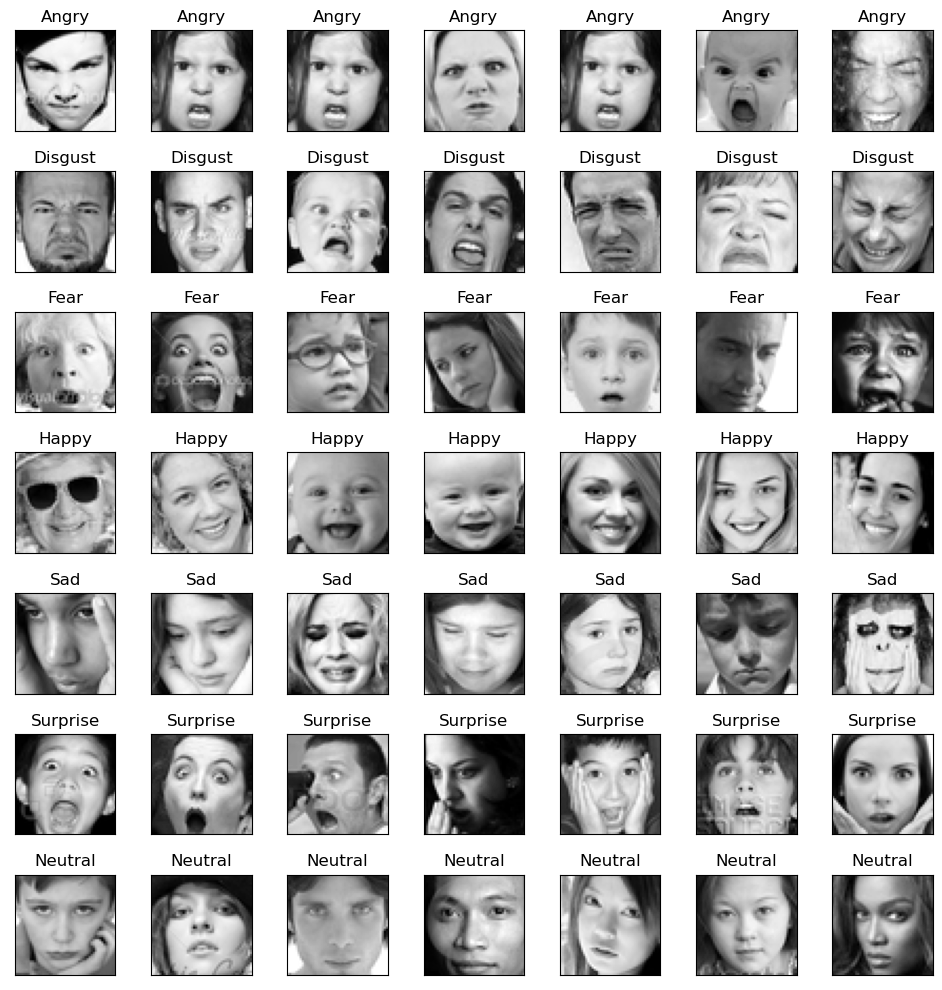

In [9]:
fig = plt.figure(1, (10, 10))

k = 0
for label in sorted(duplicates.emotion.unique()):
    for j in range(7):
        
        px = duplicates[duplicates.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

let's find out how many duplicates are within each of the emotions

In [10]:
pixel_counts = duplicates.groupby('emotion').size()
print("duplicated emotions: ", pixel_counts.sum()), print(pixel_counts)

duplicated emotions:  1853
emotion
0    226
1     87
2    301
3    193
4    155
5    745
6    146
dtype: int64


(None, None)

let's compare the duplicates of each emotion to the total number of instances within the same emotion.

for this visualization to happen a simple function will be created to see the total instances of each emotion compared to the total number for duplicates of each emotion.

In [11]:
 emotion_count = data.groupby('emotion').size()
 print("total emotions: ", emotion_count.sum()), print(emotion_count)

total emotions:  35887
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
dtype: int64


(None, None)

In [12]:
def Total_diff(data, duplicates, xtitle, lbl):

    duplic = duplicates.groupby('emotion').size()
    total = data.groupby('emotion').size()

    # Create the bar plot
    fig, ax = plt.subplots()

    # Define the width of each bar
    bar_width = 0.25

    # Define the x-axis positions
    x = np.arange(len(emotions))

    # Plot the bars for total emotions
    ax.bar(x, total, width=bar_width-0.5, label='Total Emotions')

    # Plot the bars for duplicated emotions next to the total emotions
    ax.bar(x + bar_width, duplic, width=bar_width-0.5, label=lbl)

    # Add labels and title
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')
    ax.set_title(xtitle)

    # Add x-axis tick labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(emotions)

    # Add text labels for total emotion counts
    for i, count in enumerate(total):
        ax.text(i, count + 50, str(count), ha='center', va='bottom')

    # Add text labels for duplicated emotion counts
    for i, count in enumerate(duplic):
        ax.text(i + bar_width, count + 50, str(count), ha='center', va='bottom')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


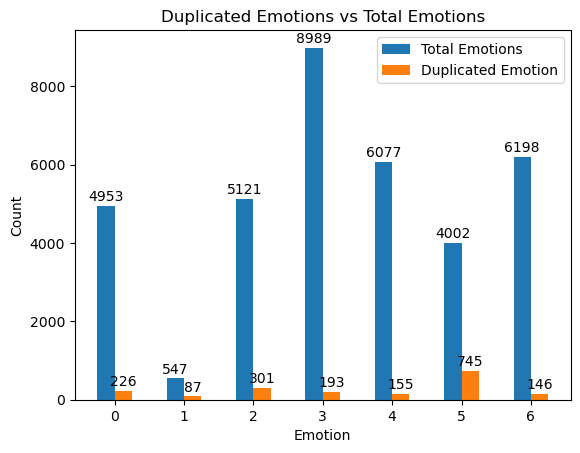

In [13]:
xtitle = "Duplicated Emotions vs Total Emotions"
label = "Duplicated Emotion"
Total_diff(data, duplicates, xtitle, label)

### Checking Outliers within the images 

Take Care!!, the dataset variable we're working on now is cleaned_df

In [14]:
def show_pixel_value_boxplot(pixel_data):
    # Calculate the average pixel value for each image
    avg_pixel_values = pixel_data.apply(lambda x: np.mean([int(pixel) for pixel in x.split()]))

    # Create a horizontal box plot of the average pixel values
    plt.figure(figsize=(14, 6)) 
    plt.boxplot(avg_pixel_values, vert=False)
    plt.xlabel('Average Pixel Value')
    plt.title('Horizontal Box plot of Average Pixel Values')

    # Customize the xticks
    min_value = int(np.min(avg_pixel_values))
    max_value = int(np.max(avg_pixel_values))
    tick_step = (max_value - min_value) // 10  # Adjust the number of ticks as needed
    plt.xticks(np.arange(min_value, max_value + tick_step, step=tick_step))

    plt.show()

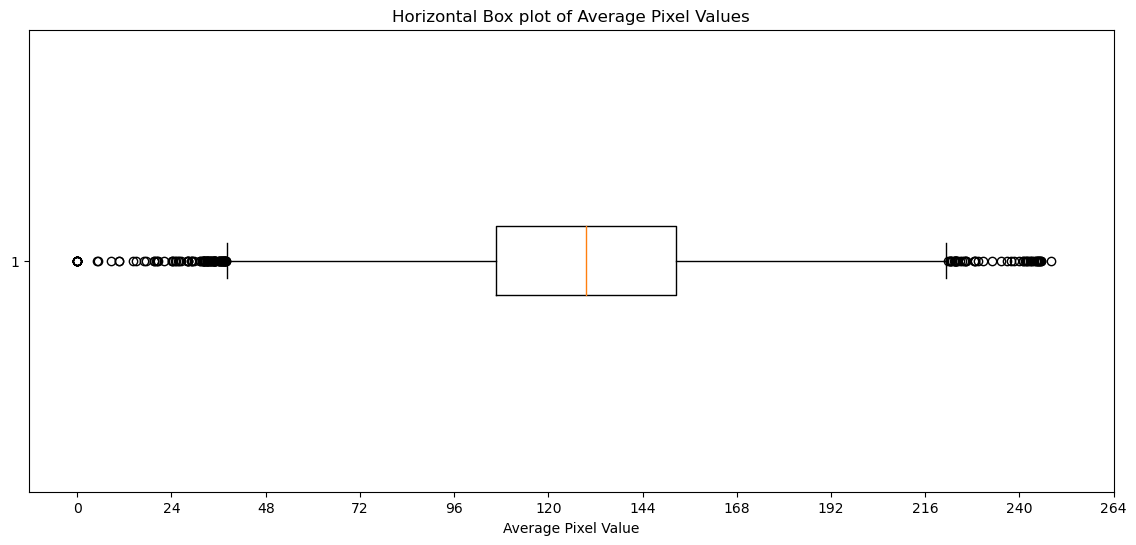

In [15]:
show_pixel_value_boxplot(data['pixels'])

In [16]:
def find_bright_outliers(pixel_data, emotion_data, threshold=130):
    # Calculate the average pixel value for each image
    avg_pixel_values = pixel_data.apply(lambda x: np.mean([int(pixel) for pixel in x.split()]))
    
    # Find images with grayscale pixel values higher than the threshold
    outlier_indices = [i for i, avg_pixel_value in enumerate(avg_pixel_values) if avg_pixel_value > threshold]

    # Create a dataframe of outlier images and their corresponding emotion labels
    outlier_df = pd.DataFrame({'pixels': pixel_data.iloc[outlier_indices].values,
                               'emotion': emotion_data.iloc[outlier_indices].values})

    return outlier_df

In [17]:
outlier_images = find_bright_outliers(data['pixels'], data['emotion'], threshold=230)
outlier_images.count()

pixels     28
emotion    28
dtype: int64

In [18]:
def plot_outlier_images(outlier_df, img_size=(48, 48), grid_size=(5, 5)):
    
    num_images = len(outlier_df)
    grid_rows, grid_cols = grid_size

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img_array = np.array(outlier_df.iloc[i]['pixels'].split(), dtype=int).reshape(img_size)
            emotion_label = outlier_df.iloc[i]['emotion']

            ax.imshow(img_array, cmap='gray')
            ax.set_title(f'Emotion: {emotions[emotion_label]}')
        else:
            ax.axis('off')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

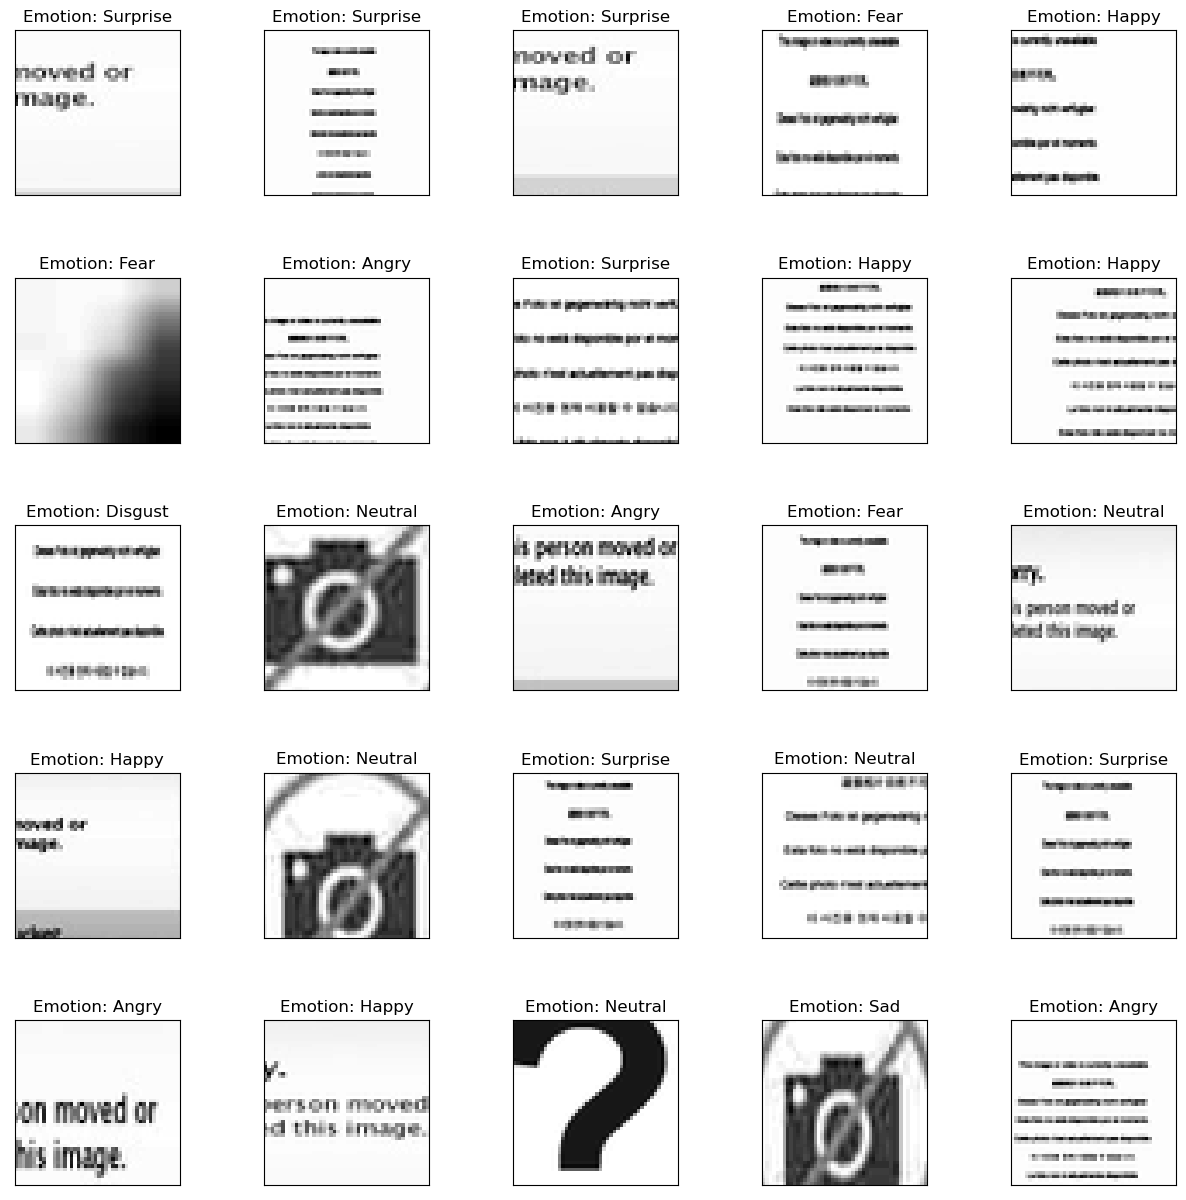

In [19]:
plot_outlier_images(outlier_images, img_size=(48, 48), grid_size=(5, 5))

In [20]:
def drop_outlier_images(original_df, outlier_df, pixel_data_col):
    
    # Merge the original dataframe with the outlier dataframe
    merged_df = pd.merge(original_df, outlier_df, on=[pixel_data_col], how='outer', indicator=True)

    # Keep only the rows that are not present in the outlier dataframe
    cleaned_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

    # Reset the index and drop the extra index column
    cleaned_df = cleaned_df.reset_index(drop=True)

    return cleaned_df

In [21]:
data.count()

emotion    35887
pixels     35887
Usage      35887
dtype: int64

In [22]:
cleaned_df = drop_outlier_images(data, outlier_images, 'pixels')
cleaned_df.count()

emotion_x    35859
pixels       35859
Usage        35859
emotion_y        0
dtype: int64

Dropping unnecessary column emotion_y, and renaming column emotion_x to emotion.

In [23]:
cleaned_df = cleaned_df.rename(columns={'emotion_x': 'emotion'})
cleaned_df = cleaned_df.drop('emotion_y', axis=1)

In [24]:
cleaned_df.keys()

Index(['emotion', 'pixels', 'Usage'], dtype='object')

### Duplicates with Non-Matching emotion

In [26]:
def duplicates_non_match_emotion(data):
    # Find duplicate rows based on the 'pixels' column
    duplicates = data[data.duplicated(subset=['pixels'], keep=False)]

    # Initialize a list to store dataframes with duplicates having non-matching emotions
    duplicate_dataframes = []

    # Iterate over each duplicate row
    for index, row in duplicates.iterrows():
        # Get the pixel value and emotion for the current row
        current_pixels = row['pixels']
        current_emotion = row['emotion']

        # Find rows with the same pixel value but different emotion
        same_pixels_diff_emotion = data[(data['pixels'] == current_pixels) & (data['emotion'] != current_emotion)]

        if not same_pixels_diff_emotion.empty:
            # Save the current row and rows with different emotions in a new dataframe
            duplicate_df = pd.concat([row.to_frame().T, same_pixels_diff_emotion], ignore_index=True)
            duplicate_dataframes.append(duplicate_df)

    return duplicate_dataframes

In [27]:
duplicate_dataframes = duplicates_non_match_emotion(cleaned_df)

for i, df in enumerate(duplicate_dataframes[:10]):
    print(f'Duplicate {i + 1}:')
    print(df)
    print('---')

Duplicate 1:
  emotion                                             pixels       Usage
0       0  254 253 252 255 227 83 50 49 38 41 43 36 57 14...    Training
1       1  254 253 252 255 227 83 50 49 38 41 43 36 57 14...  PublicTest
---
Duplicate 2:
  emotion                                             pixels       Usage
0       1  254 253 252 255 227 83 50 49 38 41 43 36 57 14...  PublicTest
1       0  254 253 252 255 227 83 50 49 38 41 43 36 57 14...    Training
---
Duplicate 3:
  emotion                                             pixels       Usage
0       0  18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...    Training
1       4  18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...  PublicTest
---
Duplicate 4:
  emotion                                             pixels       Usage
0       4  18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...  PublicTest
1       0  18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...    Training
---
Duplicate 5:
  emotion                                  

In [29]:
def show_duplicate_images(duplicate_dataframes, img_size=48):
    emotion_labels = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral',
    }
    for i, df in enumerate(duplicate_dataframes):
        fig, axs = plt.subplots(1, len(df), figsize=(5, 5))

        for j, row in df.iterrows():
            img_pixels = np.array(row['pixels'].split(), dtype=int).reshape(img_size, img_size)
            emotion_id = int(row['emotion'])  # Convert the emotion string to an integer
            emotion_label = emotion_labels[emotion_id]
            axs[j].imshow(img_pixels, cmap='gray')
            axs[j].set_title(f'Emotion: {emotion_label}')
            axs[j].axis('off')

        plt.tight_layout()
        plt.suptitle(f'Duplicate {i + 1}', fontsize=8, y=0.8)
        plt.show()

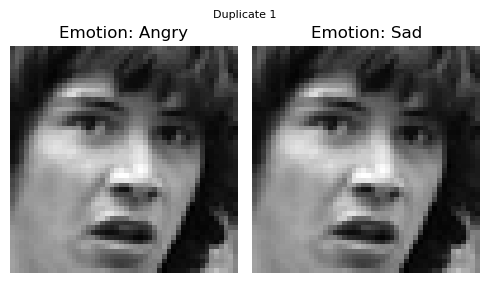

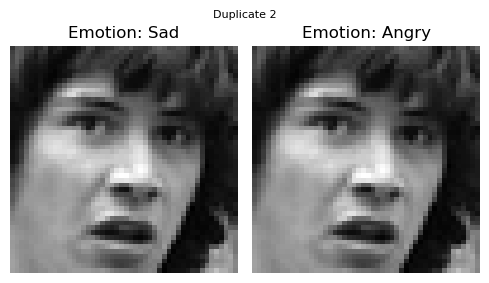

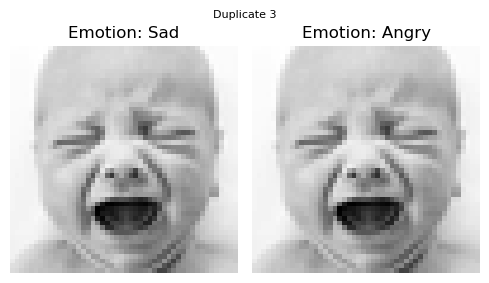

In [35]:
show_duplicate_images(duplicate_dataframes[115:118])

In [36]:
def remove_duplicates_with_diff_emotion(df):

    # Find duplicate rows based on the 'pixels' column
    duplicates = df[df.duplicated(subset=['pixels'], keep=False)]

    # Initialize a list to store the indices of rows to be removed
    indices_to_remove = []


    # Iterate over each duplicate row
    for index, row in duplicates.iterrows():
        # Get the pixel value and emotion for the current row
        current_pixels = row['pixels']
        current_emotion = row['emotion']
        
        # Find rows with the same pixel value but different emotion
        same_pixels_diff_emotion = data[(data['pixels'] == current_pixels) & (data['emotion'] != current_emotion)]

        if not same_pixels_diff_emotion.empty:
            # Add the indices of rows with different emotions to the list
            indices_to_remove.extend(same_pixels_diff_emotion.index)

    # Remove the rows with non-matching emotions
    df_cleaned = df.drop(indices_to_remove)

    # Reset the index of the cleaned dataframe
    df_cleaned = df_cleaned.reset_index(drop=True)

    return df_cleaned

In [37]:
cleaned_df.count()

emotion    35859
pixels     35859
Usage      35859
dtype: int64

In [38]:
fer = remove_duplicates_with_diff_emotion(cleaned_df)
fer.count()

emotion    35699
pixels     35699
Usage      35699
dtype: int64

### Data Pre-procesing - getting data ready to train the model

In [39]:
def pre_proc_data(data):
    # Extract the pixel data and emotion labels from the input data
    x_data = data["pixels"]
    y_data = data["emotion"]
    # Use a RandomOverSampler to balance the classes by oversampling the minority classes
    oversampler = RandomOverSampler(sampling_strategy='auto')
    x_data = np.array(list(map(str.split, x_data)), np.float32)
    x_data, y_data = oversampler.fit_resample(np.array(x_data), y_data)
    
    # Normalize the pixel data by dividing all values by 255
    x_data /= 255

    # Reshape the pixel data into a 4D array of shape (num_samples, 48, 48, 1)
    x_data = x_data.reshape(-1, 48, 48, 1)

    # Convert the emotion labels to a 2D array of shape (num_samples, 1)
    y_data = np.array(y_data)
    y_data = y_data.reshape(y_data.shape[0], 1)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=45)
    
    # Convert the emotion labels to one-hot encoded vectors
    y_train = np_utils.to_categorical(y_train, 7)
    y_test = np_utils.to_categorical(y_test, 7)
    
    # Return the processed data as a tuple of four arrays
    return x_train, x_test, y_train, y_test

In [40]:
x_train, x_val, y_train, y_val = pre_proc_data(fer)

Let's view some of the samples in x_train

In [41]:
def ViewPixelSample(data, RANGE, ydata=None):
    # Check if the input data is a Pandas DataFrame
    if isinstance(data, pd.DataFrame):
        # Extract the pixel data and emotion labels from the DataFrame
        xdata = data["pixels"]
        ydata = data["emotion"]
        # Loop over a range of images and display them with their emotion labels
        for ix in range(RANGE):
            # Create a new plot figure
            f = plt.figure(ix)
            # Set the width and height of the plot figure
            f.set_figwidth(5)
            f.set_figheight(2)
            # Remove ticks from the x and y axes
            plt.xticks([])
            plt.yticks([])
            # Set the xlabel to the name of the corresponding emotion label
            plt.xlabel(emotions[np.argmax(ydata[ix])])
            # Display the image with the corresponding pixel data
            plt.imshow(xdata[ix].reshape((48, 48)), interpolation='none', cmap='gray')
        # Show the plot
        plt.show()
    else:
        # Convert ydata to a list if it is a NumPy array
        if isinstance(ydata, np.ndarray):
            ydata = ydata.tolist()
        # Loop over a range of images and display them with their emotion labels (if provided)
        for ix in range(RANGE):
            # Create a new plot figure
            f = plt.figure(ix)
            # Set the width and height of the plot figure
            f.set_figwidth(5)
            f.set_figheight(2)
            # Remove ticks from the x and y axes
            plt.xticks([])
            plt.yticks([])
            # Set the xlabel to the name of the corresponding emotion label (if provided)
            if ydata is not None:
                plt.xlabel(emotions[np.argmax(ydata[ix])])
            # Display the image with the corresponding pixel data
            plt.imshow(data[ix].reshape((48, 48)), interpolation='none', cmap='gray')
        # Show the plot
        plt.show()


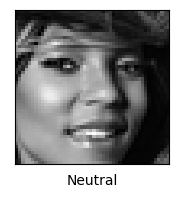

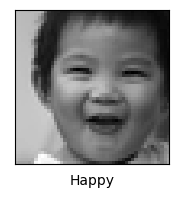

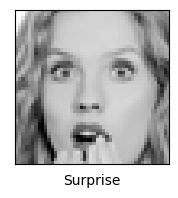

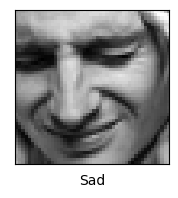

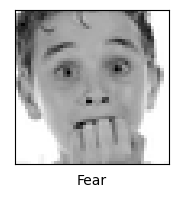

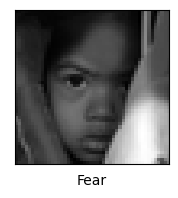

In [42]:
ViewPixelSample(x_train, 6, y_train)

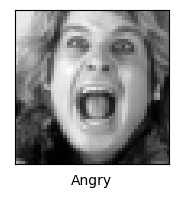

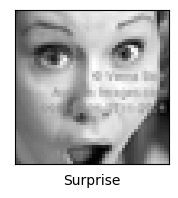

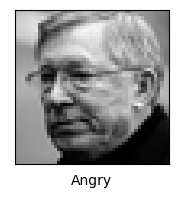

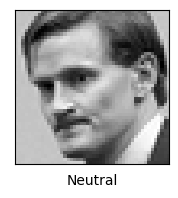

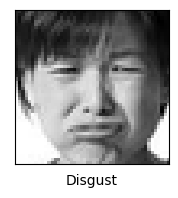

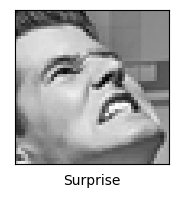

In [43]:
ViewPixelSample(x_val, 6, y_val)

In [44]:
print(x_train[0].shape)
print(y_train[0].shape)
print(x_val[0].shape)
print(y_val[0].shape)

(48, 48, 1)
(7,)
(48, 48, 1)
(7,)


### Model Architecture 

This model architecture used is a hybrid CNN-MultiHeadAttention module with all pre-processing steps which include: OutliersRemoved, Duplicates with different emotion Removed. 
The Sampling techniques used in this model is ROS

In [47]:
def create_vision_transformer_model(input_shape, num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional Block 0
    x = layers.Conv2D(32, kernel_size=2, activation='relu', padding='same')(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Block 1
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

     # Reshape and Transformer
    x = layers.MultiHeadAttention(num_heads=8, key_dim=8)(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization()(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)

    # Reshape and Transformer
    x = layers.Reshape((-1, 128))(x)
    x = layers.MultiHeadAttention(num_heads=8, key_dim=8)(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    keras.utils.plot_model(model, to_file = "TransformerVariation.png", show_shapes = True, show_dtype = True)

    return model

# Create the Vision Transformer model
input_shape = (48, 48, 1)
model = create_vision_transformer_model(input_shape, num_classes=7)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   160         ['input_2[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 48, 32)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 32)   0           ['layer_normalization[0][0]']

### Defining Callbacks

In [43]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    mid_delta=0.0001, 
    patience=2, 
    verbose=1
)

Earlystop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose =1,
)

TensBoard = TensorBoard(
    log_dir = 'logs-VariationTransformer_ROS'
)

checkpoint = ModelCheckpoint(
    filepath = 'VariationTransformer_ROS.h5',
    verbose = 1,
    save_best_only = True
)

### Compiling and fitting 

In [ ]:
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = epochs, validation_data=(x_val, y_val), batch_size=16 , callbacks=[lr_reduce, Earlystop, TensBoard, checkpoint ])

Epoch 1/100
1785/1785 [==============================] - ETA: 0s - loss: 1.8179 - accuracy: 0.2410
Epoch 1: val_loss improved from inf to 1.79135, saving model to VariationTransformer.h5
1785/1785 [==============================] - 50s 19ms/step - loss: 1.8179 - accuracy: 0.2410 - val_loss: 1.7913 - val_accuracy: 0.2594 - lr: 2.0000e-04
Epoch 2/100
1783/1785 [============================>.] - ETA: 0s - loss: 1.7770 - accuracy: 0.2602
Epoch 2: val_loss improved from 1.79135 to 1.74361, saving model to VariationTransformer.h5
1785/1785 [==============================] - 34s 19ms/step - loss: 1.7769 - accuracy: 0.2602 - val_loss: 1.7436 - val_accuracy: 0.2877 - lr: 2.0000e-04
Epoch 3/100
1783/1785 [============================>.] - ETA: 0s - loss: 1.6718 - accuracy: 0.3203
Epoch 3: val_loss improved from 1.74361 to 1.66075, saving model to VariationTransformer.h5
1785/1785 [==============================] - 32s 18ms/step - loss: 1.6717 - accuracy: 0.3204 - val_loss: 1.6608 - val_accuracy:

In [44]:
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(x_train, y_train, epochs = epochs, validation_data=(x_val, y_val), batch_size=16 , callbacks=[lr_reduce, Earlystop, TensBoard, checkpoint ])

Epoch 1/100
3130/3130 [==============================] - ETA: 0s - loss: 1.9169 - accuracy: 0.1924
Epoch 1: val_loss improved from inf to 1.86787, saving model to VariationTransformer.h5
3130/3130 [==============================] - 81s 20ms/step - loss: 1.9169 - accuracy: 0.1924 - val_loss: 1.8679 - val_accuracy: 0.2363 - lr: 2.0000e-04
Epoch 2/100
3129/3130 [============================>.] - ETA: 0s - loss: 1.7154 - accuracy: 0.3152
Epoch 2: val_loss improved from 1.86787 to 1.61958, saving model to VariationTransformer.h5
3130/3130 [==============================] - 65s 21ms/step - loss: 1.7154 - accuracy: 0.3152 - val_loss: 1.6196 - val_accuracy: 0.3594 - lr: 2.0000e-04
Epoch 3/100
3127/3130 [============================>.] - ETA: 0s - loss: 1.5440 - accuracy: 0.3906
Epoch 3: val_loss improved from 1.61958 to 1.51856, saving model to VariationTransformer.h5
3130/3130 [==============================] - 63s 20ms/step - loss: 1.5439 - accuracy: 0.3907 - val_loss: 1.5186 - val_accuracy:

### Evaluation of the model

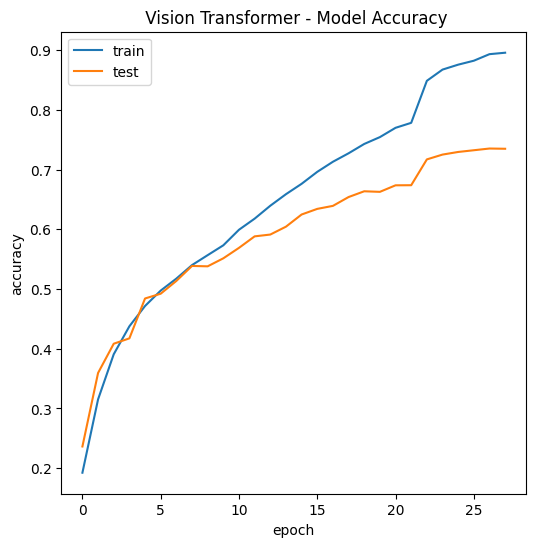

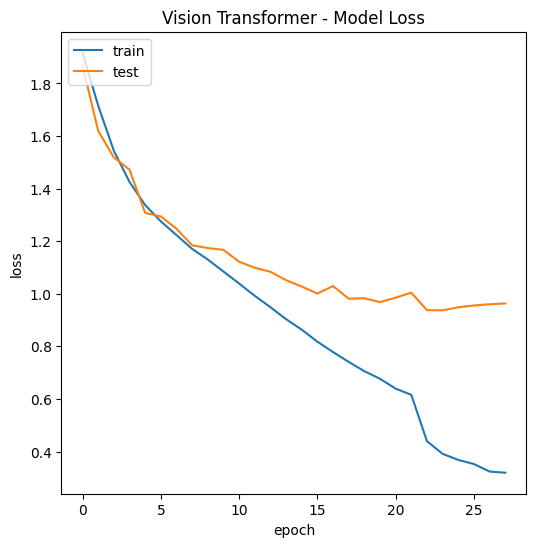

In [46]:
acc = plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(' Vision Transformer - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
acc.savefig("ACC-VisionTransformer_ROS")
plt.show()

loss = plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Vision Transformer - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
loss.savefig("LOSS-VisionTransformer_ROS")
plt.show()

In [ ]:
%load_ext tensorboard 

In [48]:
print("Accuracy of our model on validation data : " , model.evaluate(x_val, y_val)[1]*100 , "%")

392/392 [==============================] - 5s 12ms/step - loss: 0.9633 - accuracy: 0.7347
Accuracy of our model on validation data :  73.47232103347778 %


In [49]:
y_pred = model.predict(x_val)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

392/392 [==============================] - 5s 12ms/step


[4, 5, 0, 3, 1, 0, 3, 5, 2, 1]

In [50]:
y_actual = []

for pred in y_val:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[0, 5, 0, 6, 1, 5, 0, 5, 2, 1]

In [51]:
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1796
           1       0.97      1.00      0.98      1786
           2       0.70      0.66      0.68      1750
           3       0.73      0.64      0.68      1832
           4       0.58      0.58      0.58      1821
           5       0.87      0.92      0.89      1735
           6       0.61      0.65      0.63      1799

    accuracy                           0.73     12519
   macro avg       0.73      0.74      0.73     12519
weighted avg       0.73      0.73      0.73     12519



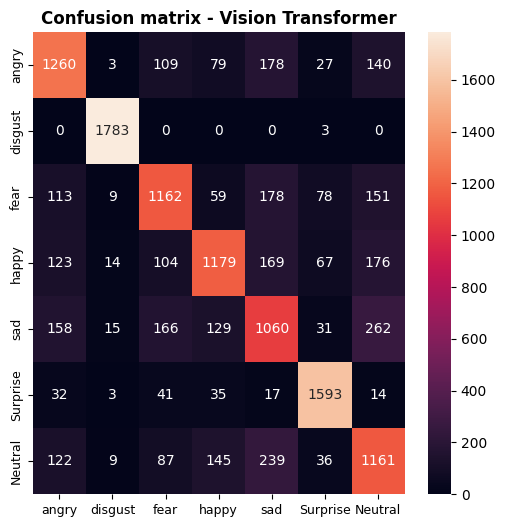

In [52]:
cm =  tf.math.confusion_matrix(labels = y_actual, predictions = y_result)


plt.figure(figsize = (6,6))
ax = plt.axes()
sn.heatmap(cm, annot = True, fmt = 'd')

ax.xaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"], fontsize=9);
ax.yaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"], fontsize=9);


plt.title('Confusion matrix - Vision Transformer', fontsize = 12, fontweight=700)


plt.savefig("ConfMat-Vision Transformer_ROS")

### Saliency Map

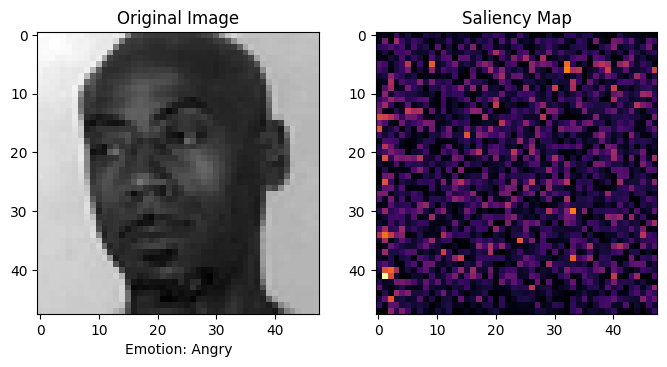

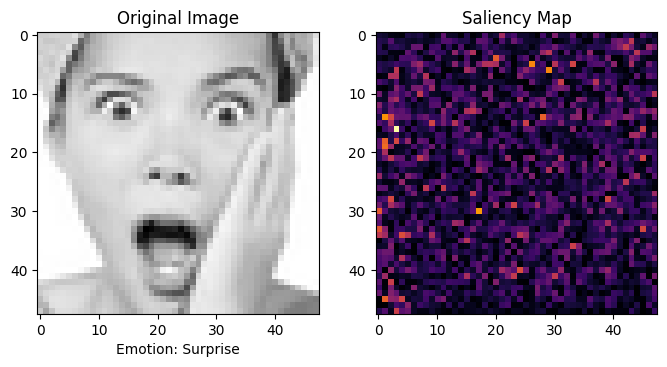

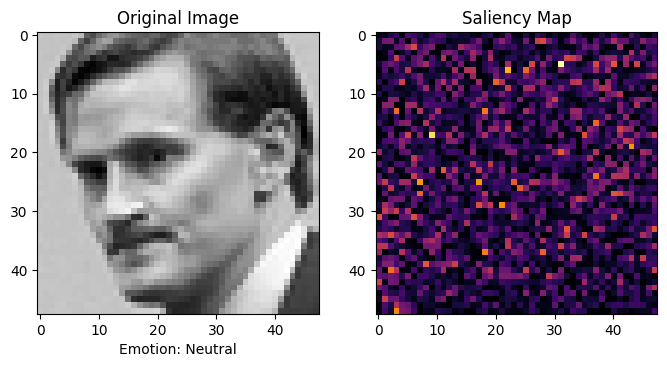

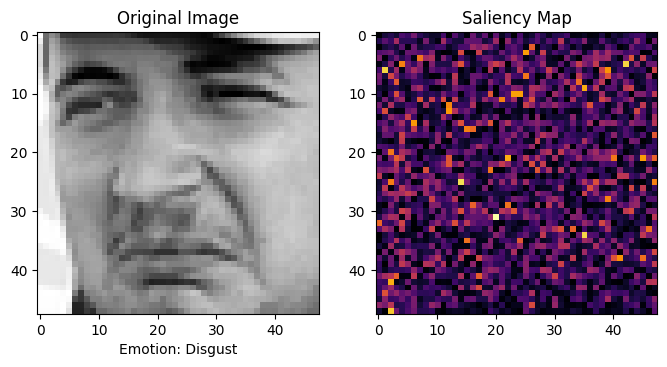

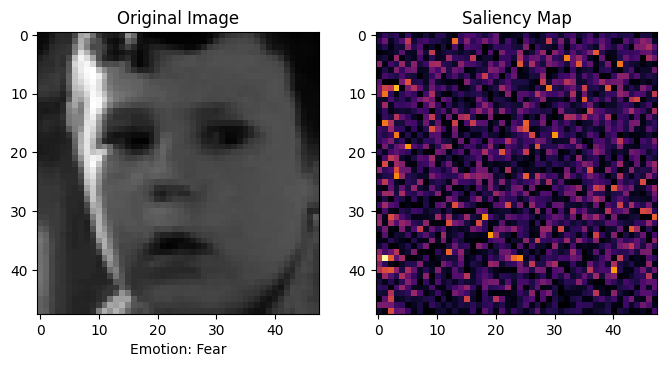

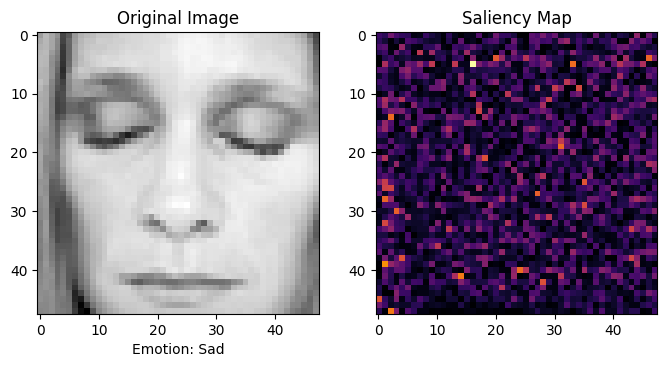

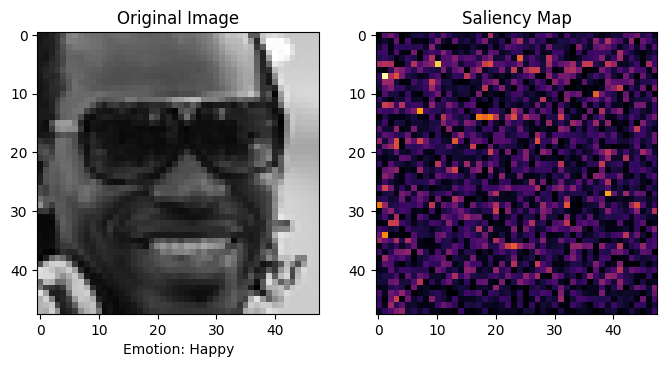

In [56]:
display_samples_and_saliency_maps(model, x_val, y_val)